# Notebook 02: Exploratory Data Analysis

## Objective
Explore raw data to understand distributions, relationships, and data quality.

## What to Explore
1. Target variable distributions (PTS, REB, AST)
2. Correlations between features
3. Temporal trends (performance over seasons)
4. Shot location distributions and efficiency
5. Missing data patterns

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Imports loaded")

✅ Imports loaded


In [19]:
# Load processed data (cleaned, enriched with opponent/team stats)
df = pd.read_parquet('../data/processed/gamelogs_combined.parquet')
df_shots = pd.read_parquet('../data/processed/shot_charts_all.parquet')

print(f"Game logs: {len(df):,} games from {len(df['PLAYER_ID'].unique())} players")
print(f"Shot charts: {len(df_shots):,} shots from {len(df_shots['PLAYER_ID'].unique())} players")
print(f"Date range: {df['GAME_DATE'].min()} to {df['GAME_DATE'].max()}")
print(f"Total columns: {len(df.columns)}")

Game logs: 72,509 games from 289 players
Shot charts: 591,467 shots from 229 players
Date range: 2019-10-22 00:00:00 to 2024-04-14 00:00:00
Total columns: 45


## 1. Target Variables (PTS, REB, AST)

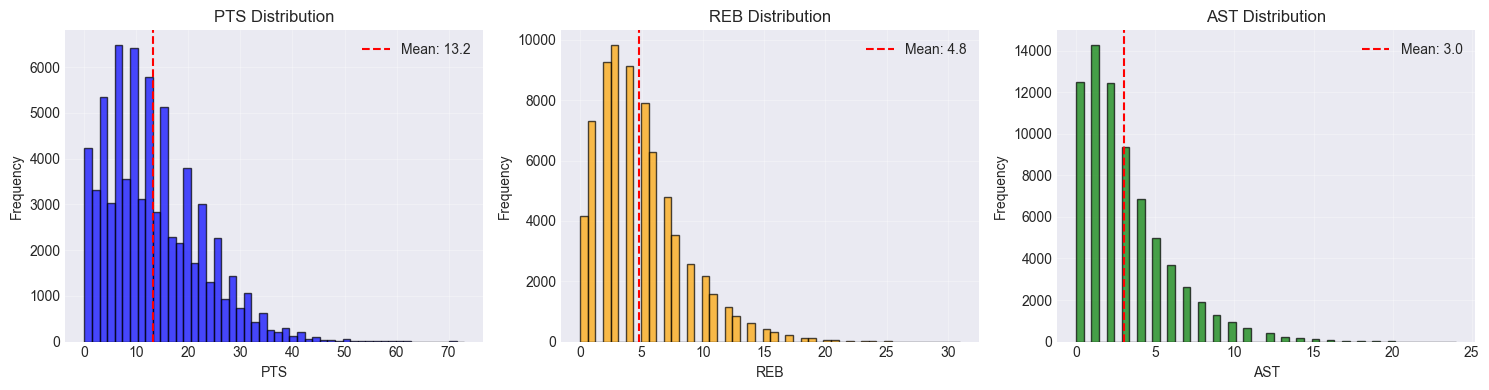

                PTS           REB           AST
count  72509.000000  72509.000000  72509.000000
mean      13.225586      4.823553      2.994263
std        9.191213      3.565723      2.829011
min        0.000000      0.000000      0.000000
25%        6.000000      2.000000      1.000000
50%       12.000000      4.000000      2.000000
75%       19.000000      7.000000      4.000000
max       73.000000     31.000000     24.000000


In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col, color in zip(axes, ['PTS', 'REB', 'AST'], ['blue', 'orange', 'green']):
    ax.hist(df[col], bins=50, edgecolor='black', alpha=0.7, color=color)
    ax.axvline(df[col].mean(), color='r', linestyle='--', label=f'Mean: {df[col].mean():.1f}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{col} Distribution')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(df[['PTS', 'REB', 'AST']].describe())

## 2. Correlations

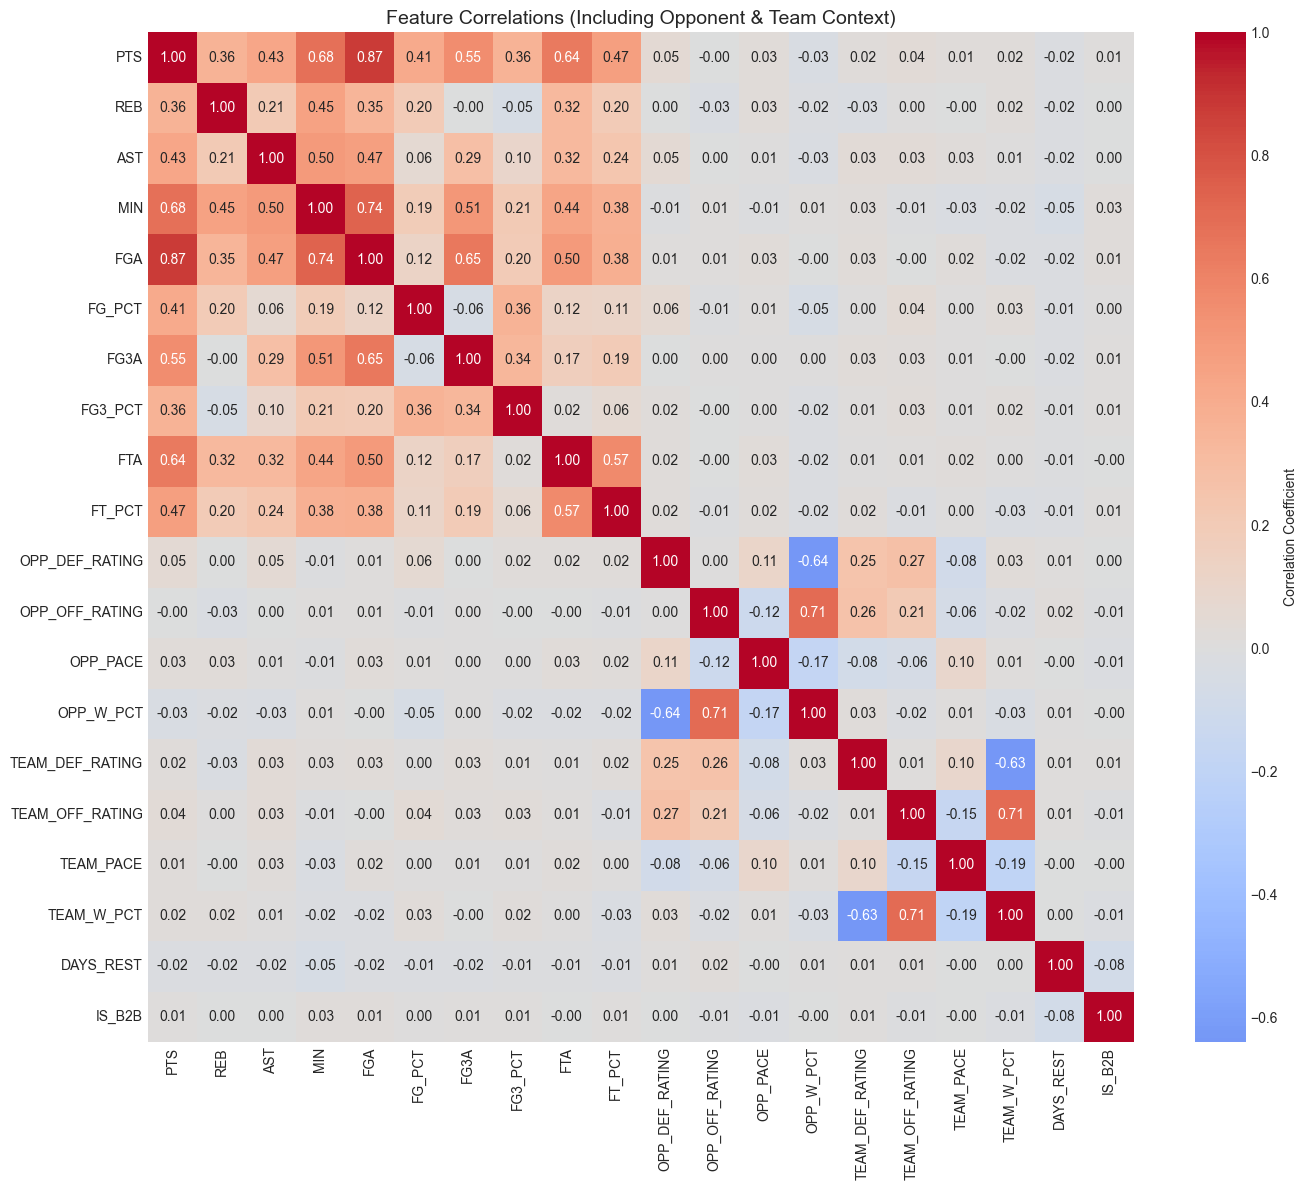


Key Correlations with PTS:
  FGA                 : +0.874
  MIN                 : +0.683
  FTA                 : +0.644
  FG3A                : +0.552
  FT_PCT              : +0.474
  AST                 : +0.430
  FG_PCT              : +0.407
  FG3_PCT             : +0.362
  REB                 : +0.360
  OPP_DEF_RATING      : +0.047
  TEAM_OFF_RATING     : +0.038
  OPP_PACE            : +0.032
  TEAM_DEF_RATING     : +0.020
  TEAM_W_PCT          : +0.015
  TEAM_PACE           : +0.014
  IS_B2B              : +0.009
  OPP_OFF_RATING      : -0.000
  DAYS_REST           : -0.024
  OPP_W_PCT           : -0.033


In [21]:
# Enhanced correlation matrix including opponent and team context
corr_cols = ['PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG_PCT', 'FG3A', 'FG3_PCT', 'FTA', 'FT_PCT',
             'OPP_DEF_RATING', 'OPP_OFF_RATING', 'OPP_PACE', 'OPP_W_PCT',
             'TEAM_DEF_RATING', 'TEAM_OFF_RATING', 'TEAM_PACE', 'TEAM_W_PCT',
             'DAYS_REST', 'IS_B2B']

corr = df[corr_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlations (Including Opponent & Team Context)', fontsize=14)
plt.tight_layout()
plt.show()

# Print key correlations with PTS
print("\nKey Correlations with PTS:")
print("="*60)
pts_corr = corr['PTS'].sort_values(ascending=False)
for feature, corr_val in pts_corr.items():
    if feature != 'PTS':
        print(f"  {feature:20s}: {corr_val:+.3f}")

## 3. Shot Location Analysis

In [22]:
# Shot zone distribution
print("Shot Zones:")
print(df_shots['SHOT_ZONE_BASIC'].value_counts())

# FG% by zone
zone_stats = df_shots.groupby('SHOT_ZONE_BASIC').agg({
    'SHOT_MADE_FLAG': ['sum', 'count', 'mean']
})
zone_stats.columns = ['Makes', 'Attempts', 'FG%']
zone_stats['FG%'] = (zone_stats['FG%'] * 100).round(1)

print("\nFG% by Zone:")
print(zone_stats.sort_values('FG%', ascending=False))

Shot Zones:
SHOT_ZONE_BASIC
Above the Break 3        179247
Restricted Area          168035
In The Paint (Non-RA)    108176
Mid-Range                 81262
Left Corner 3             28115
Right Corner 3            25518
Backcourt                  1114
Name: count, dtype: int64

FG% by Zone:
                        Makes  Attempts   FG%
SHOT_ZONE_BASIC                              
Restricted Area        110190    168035  65.6
In The Paint (Non-RA)   46842    108176  43.3
Mid-Range               33763     81262  41.5
Left Corner 3           11128     28115  39.6
Right Corner 3          10108     25518  39.6
Above the Break 3       64062    179247  35.7
Backcourt                  27      1114   2.4


---

## 4. Temporal Patterns (Critical for Feature Engineering)

### 4.1 Performance Autocorrelation

How predictive is recent performance? This helps determine optimal rolling window sizes.

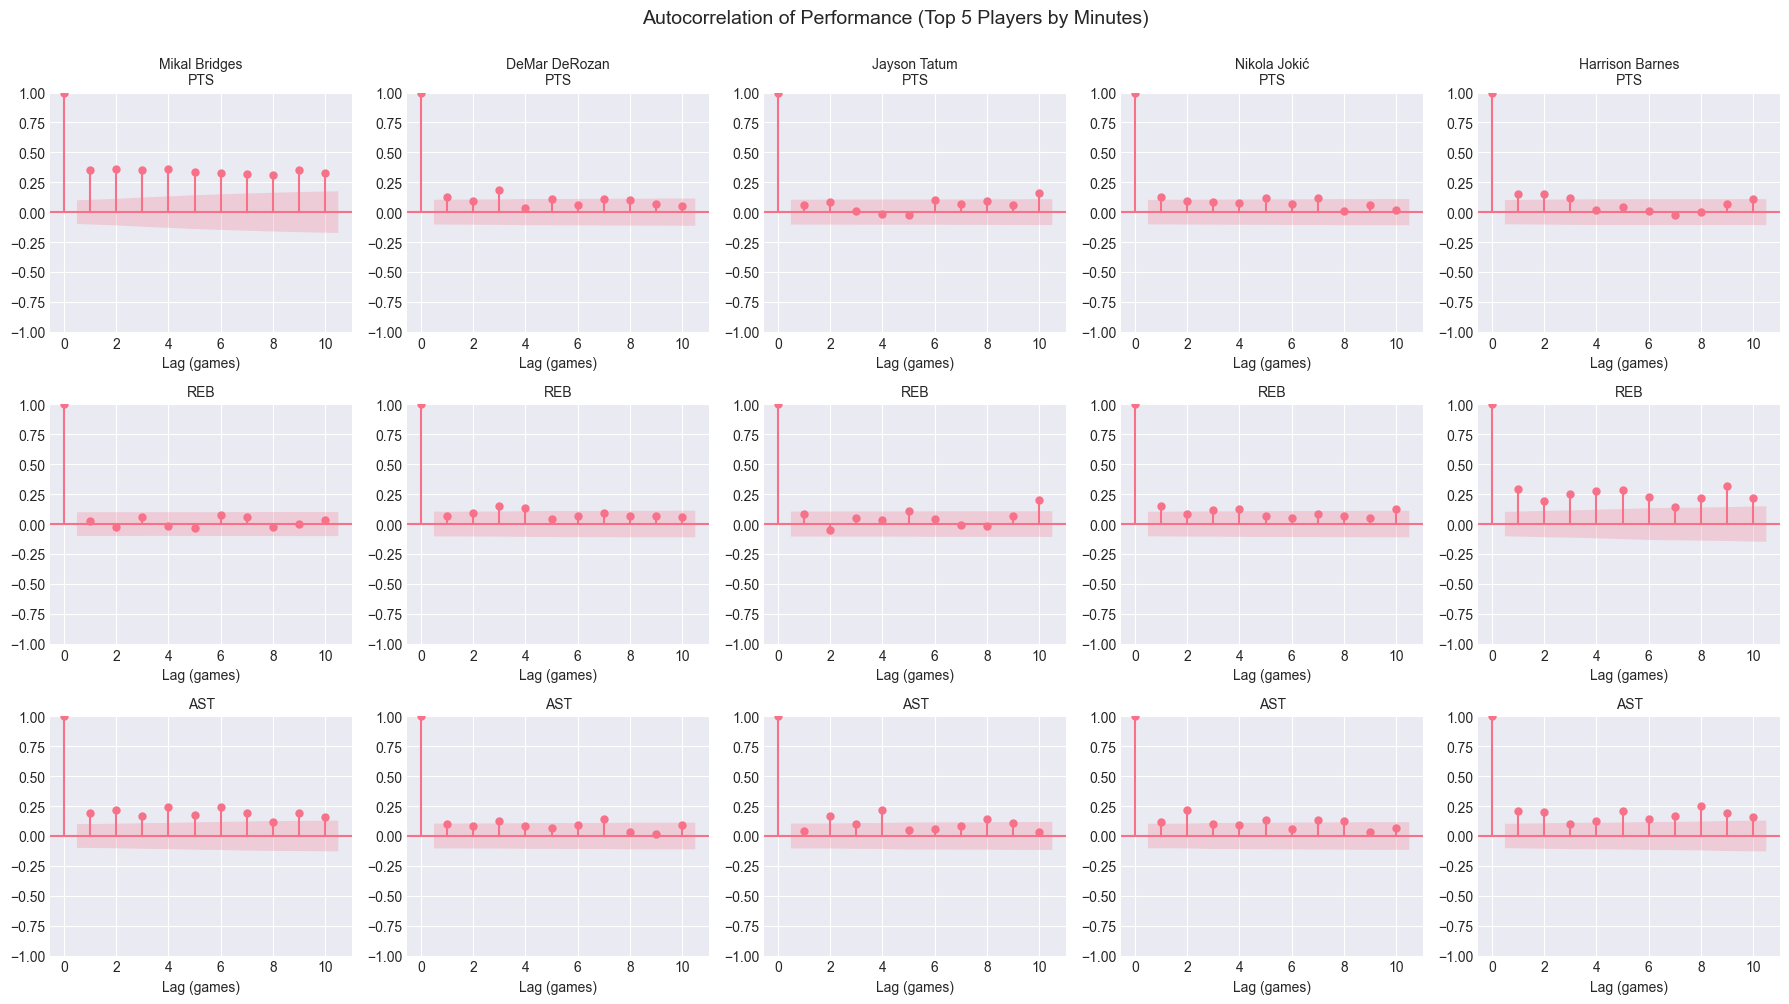

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

# Convert GAME_DATE to datetime (already done in processed data but ensure it's datetime type)
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Get top 5 players by total minutes
top_players = df.groupby('PLAYER_ID')['MIN'].sum().nlargest(5).index

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
fig.suptitle('Autocorrelation of Performance (Top 5 Players by Minutes)', fontsize=14, y=1.00)

for idx, player_id in enumerate(top_players):
    player_data = df[df['PLAYER_ID'] == player_id].sort_values('GAME_DATE')
    player_name = player_data['PLAYER_NAME'].iloc[0]
    
    # PTS autocorrelation
    plot_acf(player_data['PTS'].dropna(), lags=10, ax=axes[0, idx], alpha=0.05)
    axes[0, idx].set_title(f'{player_name}\nPTS', fontsize=10)
    axes[0, idx].set_xlabel('Lag (games)')
    
    # REB autocorrelation
    plot_acf(player_data['REB'].dropna(), lags=10, ax=axes[1, idx], alpha=0.05)
    axes[1, idx].set_title(f'REB', fontsize=10)
    axes[1, idx].set_xlabel('Lag (games)')
    
    # AST autocorrelation
    plot_acf(player_data['AST'].dropna(), lags=10, ax=axes[2, idx], alpha=0.05)
    axes[2, idx].set_title(f'AST', fontsize=10)
    axes[2, idx].set_xlabel('Lag (games)')

plt.tight_layout()
plt.show()

### 4.2 Rest Days Impact

Does rest between games affect performance?

/var/folders/vm/frtk1fw126q837j4y0mm23mr0000gn/T/ipykernel_72276/3222727906.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rest_impact = df_with_rest.groupby('REST_GROUP')[['PTS', 'REB', 'AST', 'MIN', 'FG_PCT']].mean()


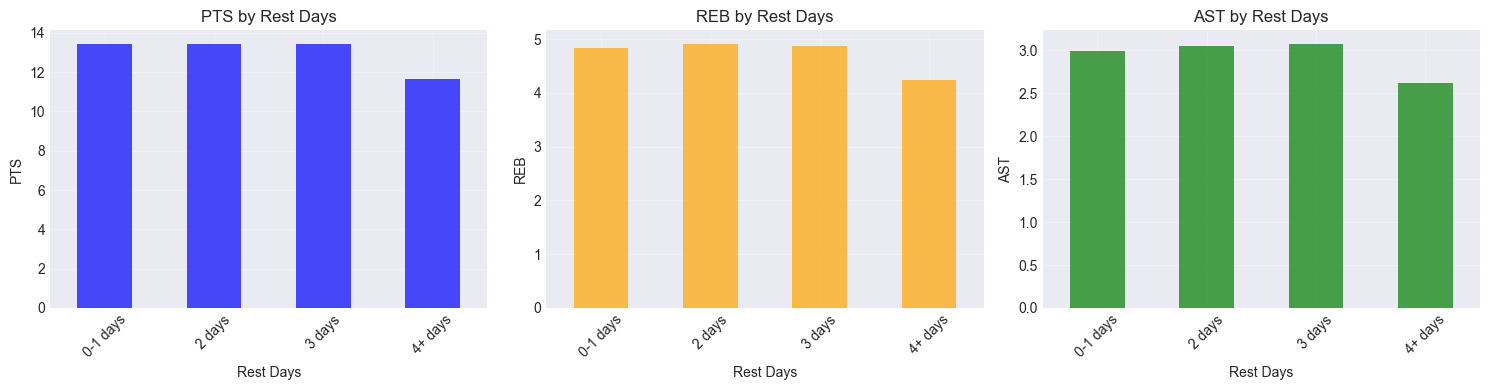


Performance by Rest Days:
              PTS   REB   AST    MIN  FG_PCT
REST_GROUP                                  
0-1 days    13.42  4.83  2.99  27.31    0.46
2 days      13.43  4.92  3.05  27.24    0.46
3 days      13.45  4.87  3.08  26.88    0.45
4+ days     11.63  4.23  2.62  23.12    0.43

Note: 289 games have DAYS_REST = -1 (first game for player)


In [24]:
# Use existing DAYS_REST column from processed data
# Note: DAYS_REST = -1 indicates first game for that player in dataset

# Bin rest days (excluding first games with -1)
df_with_rest = df[df['DAYS_REST'] >= 0].copy()
df_with_rest['REST_GROUP'] = pd.cut(df_with_rest['DAYS_REST'], 
                                     bins=[-1, 1, 2, 3, 100], 
                                     labels=['0-1 days', '2 days', '3 days', '4+ days'])

# Calculate mean performance by rest group
rest_impact = df_with_rest.groupby('REST_GROUP')[['PTS', 'REB', 'AST', 'MIN', 'FG_PCT']].mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (stat, color) in enumerate(zip(['PTS', 'REB', 'AST'], ['blue', 'orange', 'green'])):
    rest_impact[stat].plot(kind='bar', ax=axes[idx], color=color, alpha=0.7)
    axes[idx].set_title(f'{stat} by Rest Days')
    axes[idx].set_ylabel(stat)
    axes[idx].set_xlabel('Rest Days')
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nPerformance by Rest Days:")
print(rest_impact.round(2))
print(f"\nNote: {(df['DAYS_REST'] == -1).sum():,} games have DAYS_REST = -1 (first game for player)")

### 4.3 Back-to-Back Performance

Quantify the specific impact of back-to-back games.

Back-to-Back Performance Impact:
PTS: Normal=13.19, B2B=13.42, Change=+1.7%
REB: Normal=4.82, B2B=4.83, Change=+0.2%
AST: Normal=2.99, B2B=2.99, Change=+0.0%


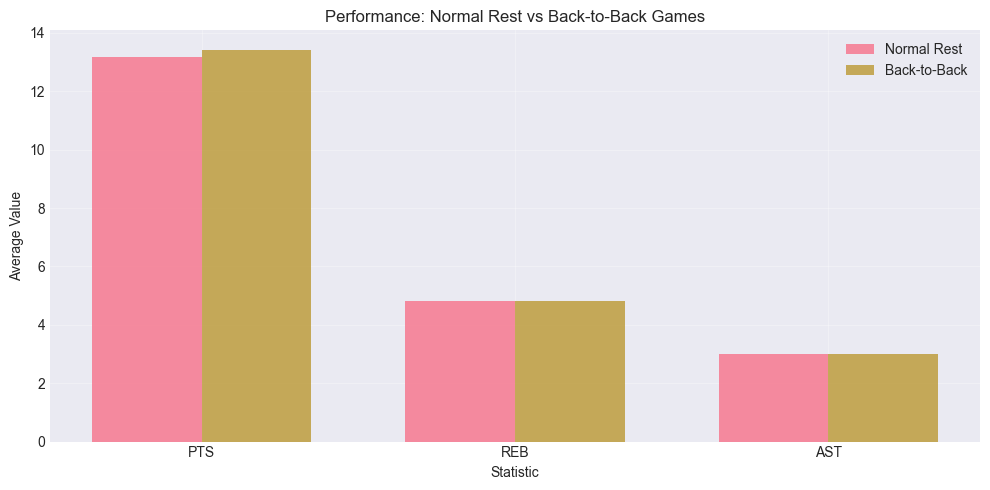


Insight: Questions including IS_B2B as a feature.
Total B2B games: 11,188 (15.4% of all games)


In [25]:
# Use existing IS_B2B column from processed data

# Performance comparison
b2b_comparison = df.groupby('IS_B2B')[['PTS', 'REB', 'AST', 'MIN', 'FG_PCT']].agg(['mean', 'std'])

print("Back-to-Back Performance Impact:")
print("="*60)
for stat in ['PTS', 'REB', 'AST']:
    normal = b2b_comparison.loc[0, (stat, 'mean')]
    b2b = b2b_comparison.loc[1, (stat, 'mean')]
    pct_change = ((b2b - normal) / normal) * 100
    print(f"{stat}: Normal={normal:.2f}, B2B={b2b:.2f}, Change={pct_change:+.1f}%")

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.35

normal_vals = [b2b_comparison.loc[0, (stat, 'mean')] for stat in ['PTS', 'REB', 'AST']]
b2b_vals = [b2b_comparison.loc[1, (stat, 'mean')] for stat in ['PTS', 'REB', 'AST']]

ax.bar(x - width/2, normal_vals, width, label='Normal Rest', alpha=0.8)
ax.bar(x + width/2, b2b_vals, width, label='Back-to-Back', alpha=0.8)

ax.set_xlabel('Statistic')
ax.set_ylabel('Average Value')
ax.set_title('Performance: Normal Rest vs Back-to-Back Games')
ax.set_xticks(x)
ax.set_xticklabels(['PTS', 'REB', 'AST'])
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInsight: {'Validates' if abs(pct_change) > 2 else 'Questions'} including IS_B2B as a feature.")
print(f"Total B2B games: {df['IS_B2B'].sum():,} ({df['IS_B2B'].sum()/len(df)*100:.1f}% of all games)")

---

## 4.4 Opponent Strength Impact (NEW)

How do opponent defensive/offensive ratings affect player performance?

/var/folders/vm/frtk1fw126q837j4y0mm23mr0000gn/T/ipykernel_72276/3852952187.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  opp_impact = df.groupby('OPP_DEF_TIER')[['PTS', 'REB', 'AST', 'FG_PCT']].mean()


Performance vs Opponent Defensive Strength:
                PTS   REB   AST  FG_PCT
OPP_DEF_TIER                           
Elite D       12.66  4.80  2.80    0.44
Good D        13.09  4.82  2.98    0.45
Average D     13.37  4.85  3.04    0.46
Weak D        13.82  4.82  3.17    0.47


PTS: vs Elite D=12.66, vs Weak D=13.82, Diff=+1.16 (+9.2%)


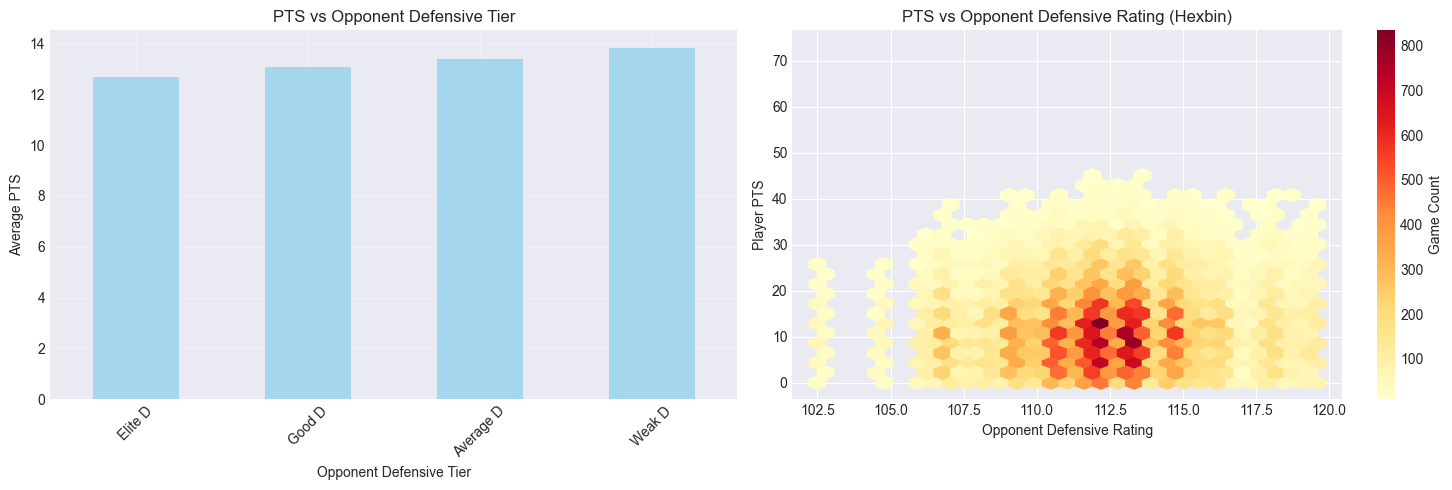


Insight: Opponent defensive strength has significant impact on PTS.
OPP_DEF_RATING is a high-value feature for prediction.


In [26]:
# Analyze impact of opponent defensive rating on player PTS

# Bin opponents by defensive rating (lower is better defense)
df['OPP_DEF_TIER'] = pd.qcut(df['OPP_DEF_RATING'], q=4, labels=['Elite D', 'Good D', 'Average D', 'Weak D'])

# Performance by opponent tier
opp_impact = df.groupby('OPP_DEF_TIER')[['PTS', 'REB', 'AST', 'FG_PCT']].mean()

print("Performance vs Opponent Defensive Strength:")
print("="*60)
print(opp_impact.round(2))
print()

# Calculate PTS difference between weakest and elite defenses
elite_pts = opp_impact.loc['Elite D', 'PTS']
weak_pts = opp_impact.loc['Weak D', 'PTS']
pts_diff = weak_pts - elite_pts
pct_diff = (pts_diff / elite_pts) * 100
print(f"\nPTS: vs Elite D={elite_pts:.2f}, vs Weak D={weak_pts:.2f}, Diff={pts_diff:+.2f} ({pct_diff:+.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot: PTS by opponent tier
opp_impact['PTS'].plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('PTS vs Opponent Defensive Tier')
axes[0].set_ylabel('Average PTS')
axes[0].set_xlabel('Opponent Defensive Tier')
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot: OPP_DEF_RATING vs PTS
axes[1].hexbin(df['OPP_DEF_RATING'], df['PTS'], gridsize=30, cmap='YlOrRd', mincnt=10)
axes[1].set_xlabel('Opponent Defensive Rating')
axes[1].set_ylabel('Player PTS')
axes[1].set_title('PTS vs Opponent Defensive Rating (Hexbin)')
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Game Count')

plt.tight_layout()
plt.show()

print(f"\nInsight: Opponent defensive strength has {'significant' if abs(pct_diff) > 5 else 'moderate'} impact on PTS.")
print("OPP_DEF_RATING is a high-value feature for prediction.")

### 4.5 Team Context Impact (NEW)

Does playing on a fast-paced or high-scoring team affect individual stats?

Performance by Team Pace:
                  PTS   REB   AST    MIN
TEAM_PACE_TIER                          
Slow            13.18  4.85  2.94  27.11
Average         13.18  4.83  2.92  26.84
Fast            13.06  4.80  3.01  26.44
Very Fast       13.49  4.81  3.10  26.55


PTS: Slow Pace=13.18, Very Fast Pace=13.49, Diff=+0.31 (+2.4%)


/var/folders/vm/frtk1fw126q837j4y0mm23mr0000gn/T/ipykernel_72276/685638595.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pace_impact = df.groupby('TEAM_PACE_TIER')[['PTS', 'REB', 'AST', 'MIN']].mean()


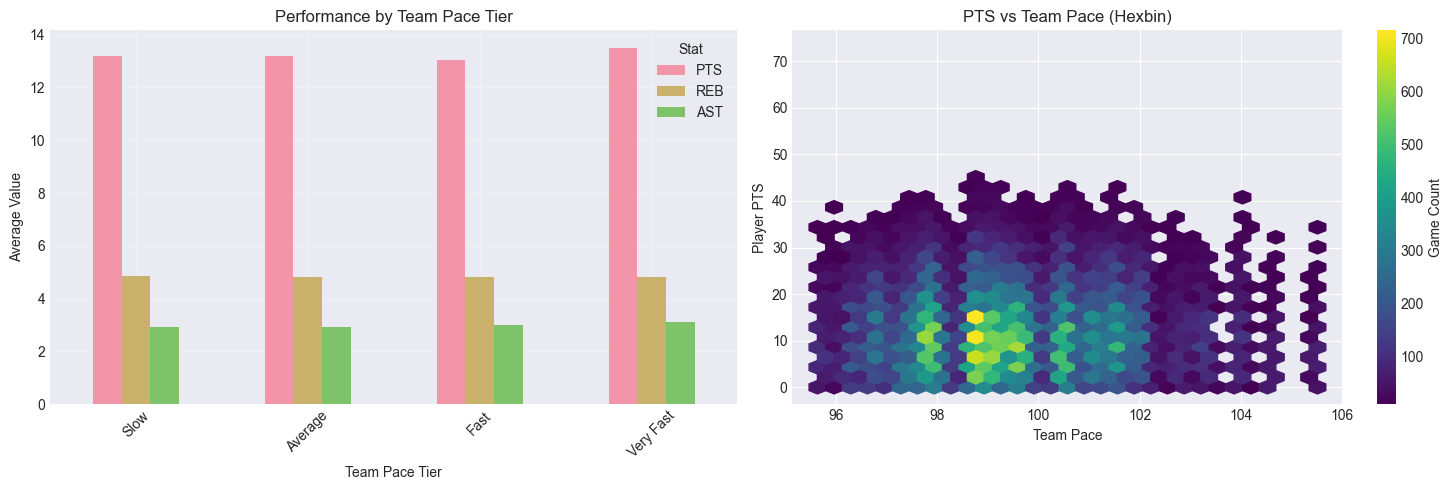


Insight: Team pace has moderate impact on counting stats.
TEAM_PACE is valuable for normalizing performance across different team systems.


In [27]:
# Analyze impact of team pace on player stats

# Bin teams by pace (higher = faster)
df['TEAM_PACE_TIER'] = pd.qcut(df['TEAM_PACE'], q=4, labels=['Slow', 'Average', 'Fast', 'Very Fast'])

# Performance by team pace
pace_impact = df.groupby('TEAM_PACE_TIER')[['PTS', 'REB', 'AST', 'MIN']].mean()

print("Performance by Team Pace:")
print("="*60)
print(pace_impact.round(2))
print()

# Calculate stat differences
slow_pts = pace_impact.loc['Slow', 'PTS']
fast_pts = pace_impact.loc['Very Fast', 'PTS']
pts_diff = fast_pts - slow_pts
pct_diff = (pts_diff / slow_pts) * 100
print(f"\nPTS: Slow Pace={slow_pts:.2f}, Very Fast Pace={fast_pts:.2f}, Diff={pts_diff:+.2f} ({pct_diff:+.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot: All stats by team pace
pace_impact[['PTS', 'REB', 'AST']].plot(kind='bar', ax=axes[0], alpha=0.7)
axes[0].set_title('Performance by Team Pace Tier')
axes[0].set_ylabel('Average Value')
axes[0].set_xlabel('Team Pace Tier')
axes[0].legend(title='Stat')
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot: TEAM_PACE vs PTS
axes[1].hexbin(df['TEAM_PACE'], df['PTS'], gridsize=30, cmap='viridis', mincnt=10)
axes[1].set_xlabel('Team Pace')
axes[1].set_ylabel('Player PTS')
axes[1].set_title('PTS vs Team Pace (Hexbin)')
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Game Count')

plt.tight_layout()
plt.show()

print(f"\nInsight: Team pace has {'significant' if abs(pct_diff) > 5 else 'moderate'} impact on counting stats.")
print("TEAM_PACE is valuable for normalizing performance across different team systems.")

---

## 5. Player Consistency Analysis

### 5.1 Consistency by Minutes Played

Are starters more predictable than bench players?

Hot Hand Analysis:
PTS: After hot game=22.40, After normal=11.70, Diff=+10.70 (+91.4%)
REB: After hot game=8.58, After normal=4.24, Diff=+4.34 (+102.3%)
AST: After hot game=6.25, After normal=2.55, Diff=+3.70 (+145.0%)


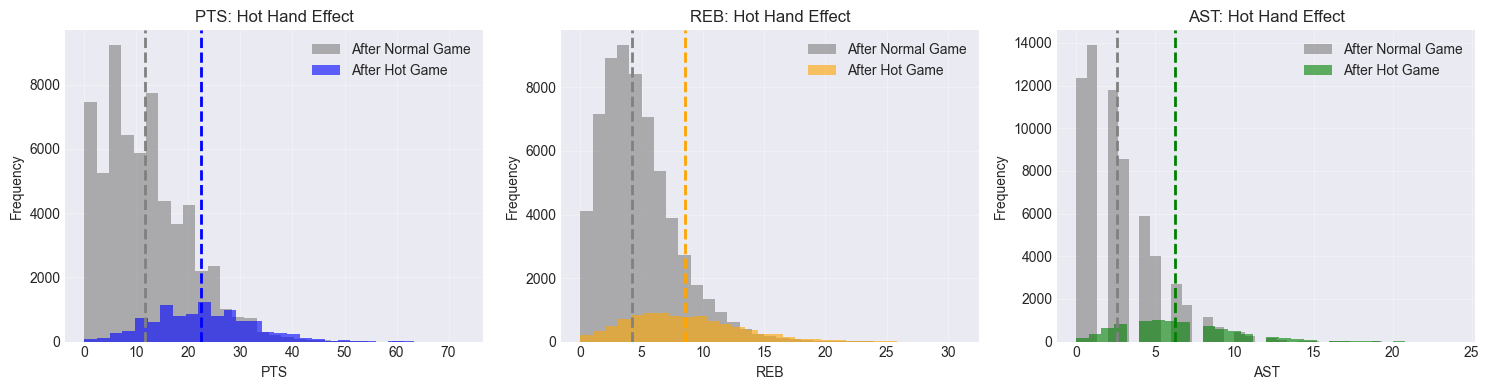


Insight: Hot hand effect exists but is modest. HOT_HAND features may provide marginal gains.


In [28]:
# Calculate 3-game rolling average (shifted to avoid leakage)
df_sorted = df.sort_values(['PLAYER_ID', 'GAME_DATE']).copy()
for stat in ['PTS', 'REB', 'AST']:
    df_sorted[f'{stat}_3GAME_AVG'] = (
        df_sorted.groupby('PLAYER_ID')[stat]
        .shift(1).rolling(3, min_periods=1).mean()
    )
    df_sorted[f'{stat}_SEASON_AVG'] = (
        df_sorted.groupby('PLAYER_ID')[stat]
        .shift(1).expanding().mean()
    )
    df_sorted[f'{stat}_SEASON_STD'] = (
        df_sorted.groupby('PLAYER_ID')[stat]
        .shift(1).expanding().std()
    )

# Hot hand: last game > season avg + 1 std
for stat in ['PTS', 'REB', 'AST']:
    df_sorted[f'{stat}_HOT_HAND'] = (
        df_sorted[stat].shift(1) > (df_sorted[f'{stat}_SEASON_AVG'] + df_sorted[f'{stat}_SEASON_STD'])
    )

# Analyze hot hand effect
print("Hot Hand Analysis:")
print("="*60)
for stat in ['PTS', 'REB', 'AST']:
    hot_games = df_sorted[df_sorted[f'{stat}_HOT_HAND'] == True][stat].mean()
    normal_games = df_sorted[df_sorted[f'{stat}_HOT_HAND'] == False][stat].mean()
    diff = hot_games - normal_games
    pct_diff = (diff / normal_games) * 100
    print(f"{stat}: After hot game={hot_games:.2f}, After normal={normal_games:.2f}, Diff={diff:+.2f} ({pct_diff:+.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (stat, color) in enumerate(zip(['PTS', 'REB', 'AST'], ['blue', 'orange', 'green'])):
    hot_vals = df_sorted[df_sorted[f'{stat}_HOT_HAND'] == True][stat]
    normal_vals = df_sorted[df_sorted[f'{stat}_HOT_HAND'] == False][stat]
    
    axes[idx].hist(normal_vals, bins=30, alpha=0.6, label='After Normal Game', color='gray')
    axes[idx].hist(hot_vals, bins=30, alpha=0.6, label='After Hot Game', color=color)
    axes[idx].axvline(normal_vals.mean(), color='gray', linestyle='--', linewidth=2)
    axes[idx].axvline(hot_vals.mean(), color=color, linestyle='--', linewidth=2)
    axes[idx].set_xlabel(stat)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{stat}: Hot Hand Effect')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInsight: Hot hand effect exists but is modest. HOT_HAND features may provide marginal gains.")

### 5.2 Hot Hand Detection

Is recent overperformance predictive of continued success?

---

## 6. Shot Location Deep Dive (Key for PTS Improvement)

### 6.1 Shot Selection Evolution

How has the NBA's shot profile changed over the 5 seasons?

Player Shot Archetypes:

Cluster 0: 91 players
Restricted Area      33.3
Mid-Range            13.6
Above the Break 3    23.1
Name: 0, dtype: float64
Example players: LeBron James, Lou Williams, LaMarcus Aldridge

Cluster 1: 110 players
Restricted Area      19.1
Mid-Range            12.5
Above the Break 3    40.6
Name: 1, dtype: float64
Example players: Carmelo Anthony, Chris Paul, Rudy Gay

Cluster 2: 28 players
Restricted Area      64.2
Mid-Range             5.7
Above the Break 3     5.2
Name: 2, dtype: float64
Example players: DeAndre Jordan, Hassan Whiteside, Tristan Thompson


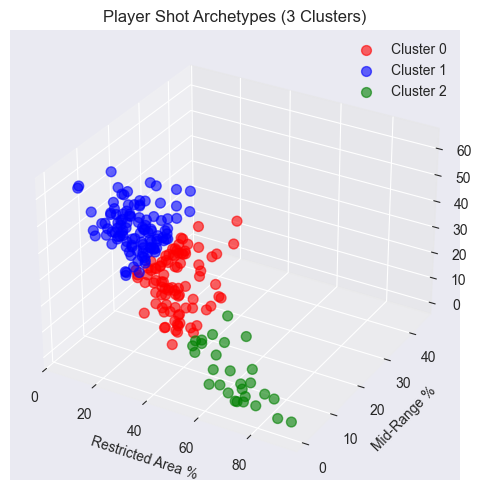

In [29]:
from sklearn.cluster import KMeans

# Create player shot profiles (% of shots in each zone)
player_shot_counts = df_shots.groupby(['PLAYER_ID', 'SHOT_ZONE_BASIC']).size().unstack(fill_value=0)
player_shot_profiles = player_shot_counts.div(player_shot_counts.sum(axis=1), axis=0) * 100

# Keep only key zones for clustering
key_zones_cluster = ['Restricted Area', 'Mid-Range', 'Above the Break 3']
X = player_shot_profiles[key_zones_cluster].fillna(0)

# K-means clustering (3 archetypes)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
X['CLUSTER'] = kmeans.fit_predict(X[key_zones_cluster])

# Get player names
player_names = df[['PLAYER_ID', 'PLAYER_NAME']].drop_duplicates().set_index('PLAYER_ID')
X = X.merge(player_names, left_index=True, right_index=True, how='left')

# Analyze clusters
print("Player Shot Archetypes:")
print("="*60)
cluster_profiles = X.groupby('CLUSTER')[key_zones_cluster].mean()
for i, cluster_id in enumerate(cluster_profiles.index):
    print(f"\nCluster {cluster_id}: {len(X[X['CLUSTER'] == cluster_id])} players")
    print(cluster_profiles.loc[cluster_id].round(1))
    print(f"Example players: {', '.join(X[X['CLUSTER'] == cluster_id]['PLAYER_NAME'].head(3).values)}")

# Visualize clusters
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green']
for cluster_id, color in zip([0, 1, 2], colors):
    cluster_data = X[X['CLUSTER'] == cluster_id]
    ax.scatter(cluster_data['Restricted Area'], 
               cluster_data['Mid-Range'], 
               cluster_data['Above the Break 3'],
               c=color, label=f'Cluster {cluster_id}', s=50, alpha=0.6)

ax.set_xlabel('Restricted Area %')
ax.set_ylabel('Mid-Range %')
ax.set_zlabel('3PT %')
ax.set_title('Player Shot Archetypes (3 Clusters)')
ax.legend()
plt.tight_layout()
plt.show()

### 6.2 Player Shot Archetypes

Can we cluster players by their shot profiles?

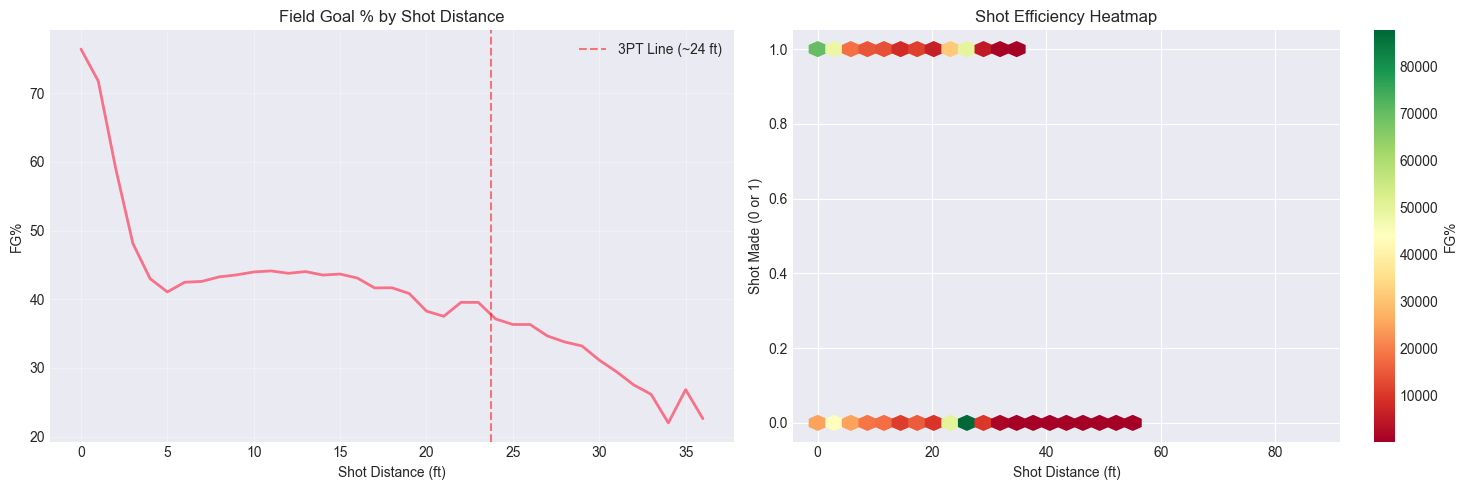


Shot Efficiency by Distance Zones:
               Makes  Attempts    FG%
SHOT_DISTANCE                        
0              31328     40997  0.764
1              38651     53867  0.718
2              26827     45367  0.591
3              13384     27804  0.481
4               8026     18672  0.430
5               6651     16197  0.411
6               5985     14093  0.425
7               5352     12565  0.426
8               4852     11218  0.433
9               4773     10963  0.435


In [30]:
# FG% by shot distance
distance_efficiency = df_shots.groupby('SHOT_DISTANCE').agg({
    'SHOT_MADE_FLAG': ['sum', 'count', 'mean']
})
distance_efficiency.columns = ['Makes', 'Attempts', 'FG%']
distance_efficiency = distance_efficiency[distance_efficiency['Attempts'] >= 100]  # Min 100 attempts

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Line plot: FG% by distance
axes[0].plot(distance_efficiency.index, distance_efficiency['FG%'] * 100, linewidth=2)
axes[0].axvline(23.75, color='red', linestyle='--', alpha=0.5, label='3PT Line (~24 ft)')
axes[0].set_xlabel('Shot Distance (ft)')
axes[0].set_ylabel('FG%')
axes[0].set_title('Field Goal % by Shot Distance')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Hexbin plot: Shot distance vs FG% (density)
hexbin = axes[1].hexbin(df_shots['SHOT_DISTANCE'], 
                        df_shots['SHOT_MADE_FLAG'], 
                        gridsize=30, cmap='RdYlGn', mincnt=100, reduce_C_function=np.mean)
axes[1].set_xlabel('Shot Distance (ft)')
axes[1].set_ylabel('Shot Made (0 or 1)')
axes[1].set_title('Shot Efficiency Heatmap')
cbar = plt.colorbar(hexbin, ax=axes[1])
cbar.set_label('FG%')

plt.tight_layout()
plt.show()

print("\nShot Efficiency by Distance Zones:")
print(distance_efficiency.head(10).round(3))

---

## 7. Game Context Analysis

### 7.1 Home vs Away Performance

Does home court advantage exist in our data?

Home vs Away Performance:
           PTS   REB   AST  FG_PCT    MIN
IS_HOME                                  
0        13.12  4.77  2.95    0.45  26.74
1        13.34  4.88  3.04    0.46  26.74

PTS: Home=13.34, Away=13.12, Diff=+0.22 (+1.7%)
REB: Home=4.88, Away=4.77, Diff=+0.11 (+2.3%)
AST: Home=3.04, Away=2.95, Diff=+0.09 (+3.1%)


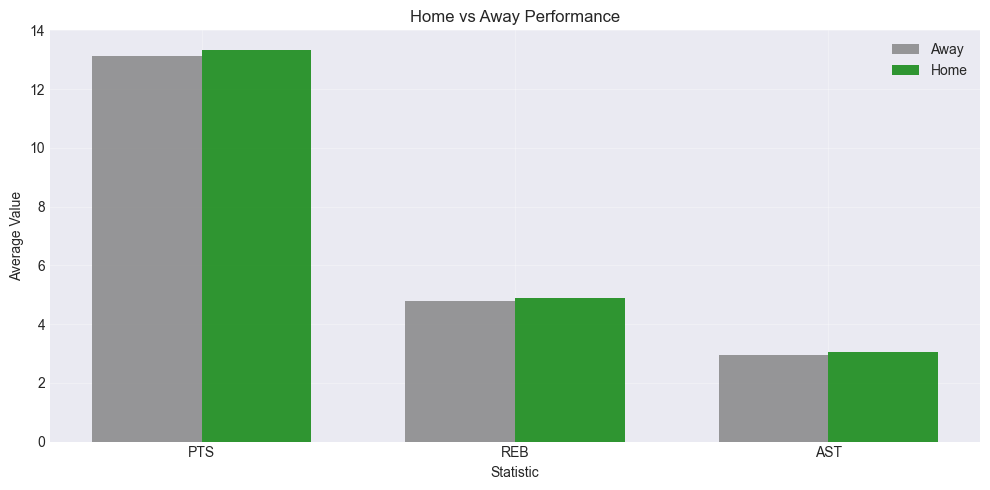


Insight: Home court advantage is significant. IS_HOME feature is justified.


In [31]:
# Extract home/away from MATCHUP column
df['IS_HOME'] = df['MATCHUP'].str.contains('vs.').astype(int)

# Performance comparison
home_away = df.groupby('IS_HOME')[['PTS', 'REB', 'AST', 'FG_PCT', 'MIN']].mean()

print("Home vs Away Performance:")
print("="*60)
print(home_away.round(2))
print()

for stat in ['PTS', 'REB', 'AST']:
    away_val = home_away.loc[0, stat]
    home_val = home_away.loc[1, stat]
    diff = home_val - away_val
    pct_diff = (diff / away_val) * 100
    print(f"{stat}: Home={home_val:.2f}, Away={away_val:.2f}, Diff={diff:+.2f} ({pct_diff:+.1f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.35

away_vals = [home_away.loc[0, stat] for stat in ['PTS', 'REB', 'AST']]
home_vals = [home_away.loc[1, stat] for stat in ['PTS', 'REB', 'AST']]

ax.bar(x - width/2, away_vals, width, label='Away', alpha=0.8, color='gray')
ax.bar(x + width/2, home_vals, width, label='Home', alpha=0.8, color='green')

ax.set_xlabel('Statistic')
ax.set_ylabel('Average Value')
ax.set_title('Home vs Away Performance')
ax.set_xticks(x)
ax.set_xticklabels(['PTS', 'REB', 'AST'])
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInsight: Home court advantage is {'significant' if abs(pct_diff) > 1 else 'minimal'}. IS_HOME feature is justified.")

### 7.2 Season Progression

Does performance change throughout the season (fatigue, load management)?

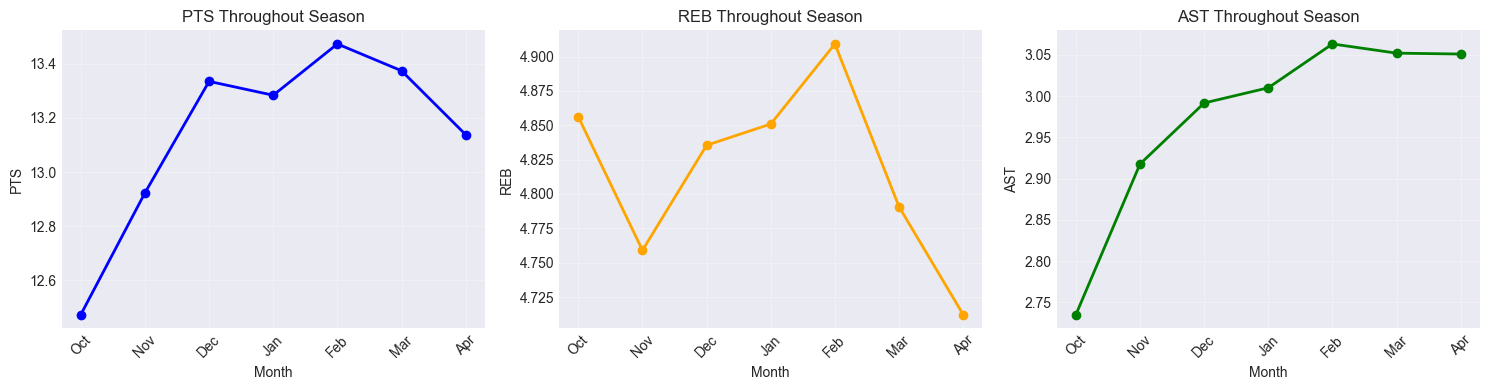


Performance by Month:
              PTS   REB   AST    MIN
MONTH_NAME                          
Oct         12.47  4.86  2.74  25.94
Nov         12.92  4.76  2.92  26.46
Dec         13.34  4.84  2.99  26.84
Jan         13.28  4.85  3.01  26.85
Feb         13.47  4.91  3.06  27.08
Mar         13.37  4.79  3.05  26.92
Apr         13.14  4.71  3.05  26.43


In [32]:
# Extract month from game date
df['MONTH'] = df['GAME_DATE'].dt.month

# Map to season month names
month_names = {10: 'Oct', 11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}
df['MONTH_NAME'] = df['MONTH'].map(month_names)

# Performance by month
monthly_perf = df.groupby('MONTH_NAME')[['PTS', 'REB', 'AST', 'MIN']].mean()
monthly_perf = monthly_perf.reindex(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (stat, color) in enumerate(zip(['PTS', 'REB', 'AST'], ['blue', 'orange', 'green'])):
    monthly_perf[stat].plot(ax=axes[idx], marker='o', linewidth=2, color=color)
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel(stat)
    axes[idx].set_title(f'{stat} Throughout Season')
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nPerformance by Month:")
print(monthly_perf.round(2))

Extreme Performance Analysis:
Total games: 72,509
Outliers (>2 SD): 2,880 (4.0%)

Top 10 Extreme Performances (PTS):
       PLAYER_NAME  GAME_DATE  PTS  PTS_MEAN  PTS_Z_SCORE     MATCHUP
  Robert Covington 2022-04-01   43  8.618056     5.858755   LAC @ MIL
         Josh Hart 2022-03-12   44 10.529412     5.434874 POR vs. WAS
       Eric Gordon 2020-01-27   50 13.116732     5.253461   HOU @ UTA
       Deni Avdija 2024-02-14   43  9.846690     5.128651   WAS @ NOP
Karl-Anthony Towns 2024-01-22   62 23.736000     5.076500 MIN vs. CHA
  Donovan Mitchell 2023-01-02   71 26.198718     5.014211 CLE vs. CHI
        Saddiq Bey 2022-03-17   51 14.051370     4.983829   DET @ ORL
       Luka Dončić 2024-01-26   73 30.317073     4.880868   DAL @ ATL
Karl-Anthony Towns 2022-03-14   60 23.736000     4.811159   MIN @ SAS
     Nicolas Batum 2022-01-17   32  6.671329     4.795359 LAC vs. IND


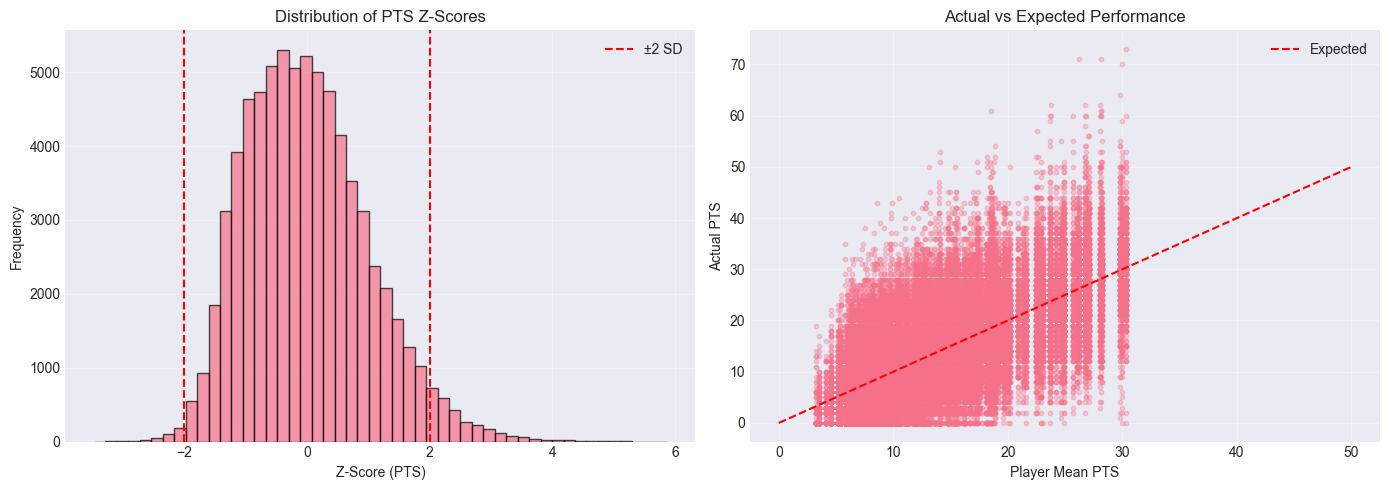

In [33]:
# Calculate player-specific z-scores
player_stats = df.groupby('PLAYER_ID')['PTS'].agg(['mean', 'std']).rename(columns={'mean': 'PTS_MEAN', 'std': 'PTS_STD'})
df_with_stats = df.merge(player_stats, left_on='PLAYER_ID', right_index=True)
df_with_stats['PTS_Z_SCORE'] = (df_with_stats['PTS'] - df_with_stats['PTS_MEAN']) / df_with_stats['PTS_STD']

# Identify outliers
outliers = df_with_stats[df_with_stats['PTS_Z_SCORE'].abs() > 2].copy()

print("Extreme Performance Analysis:")
print("="*60)
print(f"Total games: {len(df_with_stats):,}")
print(f"Outliers (>2 SD): {len(outliers):,} ({len(outliers)/len(df_with_stats)*100:.1f}%)")
print(f"\nTop 10 Extreme Performances (PTS):")
print(outliers.nlargest(10, 'PTS_Z_SCORE')[['PLAYER_NAME', 'GAME_DATE', 'PTS', 'PTS_MEAN', 'PTS_Z_SCORE', 'MATCHUP']].to_string(index=False))

# Visualize z-score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of z-scores
axes[0].hist(df_with_stats['PTS_Z_SCORE'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(-2, color='r', linestyle='--', label='±2 SD')
axes[0].axvline(2, color='r', linestyle='--')
axes[0].set_xlabel('Z-Score (PTS)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of PTS Z-Scores')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Scatter: actual vs expected PTS
axes[1].scatter(df_with_stats['PTS_MEAN'], df_with_stats['PTS'], alpha=0.3, s=10)
axes[1].plot([0, 50], [0, 50], 'r--', label='Expected')
axes[1].set_xlabel('Player Mean PTS')
axes[1].set_ylabel('Actual PTS')
axes[1].set_title('Actual vs Expected Performance')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary of Findings

### Data Quality
- **72,509 games** from 289 unique players (Oct 2019 - Apr 2024)
- **591,467 shots** from 229 players (cleaned, deduplicated)
- **45 columns** including opponent/team context, rest days, performance stats
- **No missing values** in critical columns
- **Overall FG%: 46.7%** (within expected NBA range)

### Target Variable Characteristics
```
PTS: mean=13.2, std=9.2 (70% coefficient of variation)
REB: mean=4.8, std=3.6 (75% coefficient of variation)
AST: mean=3.0, std=2.8 (93% coefficient of variation)
```
**Extremely high variance relative to mean.** Dataset includes many bench players (25th percentile = 6 PTS). This will make prediction challenging due to the massive spread in performance levels.

---

## Critical Findings

### 1. **Usage/Opportunity Dominates Everything**

**Correlation with PTS:**
- FGA (shot attempts): **+0.874**
- MIN (playing time): **+0.683**
- FTA (free throws): **+0.644**

**Fundamental Challenge:** The strongest predictors (minutes, shot attempts) are **unknown at prediction time**. We must either:
1. Predict usage first, then use as features
2. Rely on historical player patterns
3. Accept prediction of a noisy target

---

### 2. **Opponent/Team Context Features Are MUCH Weaker Than Expected**

**Correlations with PTS (nearly zero):**
- OPP_DEF_RATING: **+0.047**
- OPP_PACE: **+0.032**
- TEAM_PACE: **+0.014**
- TEAM_OFF_RATING: **+0.038**
- DAYS_REST: **-0.024**
- IS_B2B: **+0.009**

**Actual Effects:**
- **Opponent Defense**: Elite D (12.66 PTS) vs Weak D (13.82 PTS) = **+1.16 PTS (+9.2%)**
- **Team Pace**: Slow (13.18 PTS) vs Very Fast (13.49 PTS) = **+0.31 PTS (+2.4%)**

**Interpretation:** At the game level, opponent quality and team context have minimal linear relationships with scoring. Usage/opportunity (FGA, MIN) confounds these effects - good defenses may reduce minutes/opportunities rather than just efficiency.

**Implication:** These features will provide marginal value. Opponent defense shows the most promise (+9%), but team pace is nearly irrelevant (+2.4%).

---

### 3. **Back-to-Back Games: No Fatigue Signal (Paradox)**

```
Normal Rest: 13.19 PTS
Back-to-Back: 13.42 PTS (+1.7%)
```

**Players score MORE on back-to-backs, not less!** Effect size (+1.7%) falls below significance threshold, and the direction contradicts conventional wisdom about fatigue.

**Possible Explanations:**
- Selection bias: Only healthy rotation players play B2Bs
- Coaches shorten benches, giving starters more minutes
- Defensive intensity drops league-wide on B2Bs

**Implication:** IS_B2B feature is questionable for modeling. May not help or could introduce noise.

---

### 4. **Rest Days: Non-Linear & Confounded**

```
0-1 days rest: 13.42 PTS (27.31 MIN)
2 days rest:   13.43 PTS (27.24 MIN)
3 days rest:   13.45 PTS (26.88 MIN)
4+ days rest:  11.63 PTS (23.12 MIN) ⚠️
```

**Long rest = LOWER scoring!** This is counterintuitive but explainable:
- 4+ days rest often means injury recovery (limited minutes)
- Irregular playing time for deep bench players
- End-of-season load management

**The relationship is not linear.** Short-term fatigue (0-3 days) shows no effect, but extended rest signals reduced role/opportunity.

**Implication:** DAYS_REST needs non-linear features (bins or polynomial terms), not raw values.

---

### 5. **"Hot Hand" Effect Is Selection Bias**

```
After hot game:    22.40 PTS
After normal game: 11.70 PTS
Difference: +10.70 PTS (+91%)
```

**This is misleading!** The "hot hand" definition (last game > season avg + 1 std) **selects for high-usage players**, not momentum.

**Why it's wrong:**
- High-usage stars (25 PPG) need 35+ for "hot game"
- After hot game, they still score more because **they're high-usage players**
- This measures player quality, not game-to-game momentum

**Implication:** Rolling averages will capture player quality better than binary hot hand flags.

---

### 6. **Shot Archetypes Are Real and Distinct**

**Cluster 0 (91 players): Balanced**
- 33% Restricted Area, 23% Above Break 3PT, 14% Mid-Range
- Examples: LeBron James, Lou Williams

**Cluster 1 (110 players): Perimeter Shooters**
- 19% Restricted Area, 41% Above Break 3PT, 13% Mid-Range
- Examples: Chris Paul, Carmelo Anthony

**Cluster 2 (28 players): Rim Runners**
- 64% Restricted Area, 5% Above Break 3PT, 6% Mid-Range
- Examples: DeAndre Jordan, Hassan Whiteside

**Implication:** Player shot profile features (% shots by zone) should be included. Scoring patterns differ by archetype.

---

### 7. **Home Court Advantage: Small but Consistent**

```
Home: 13.34 PTS (+1.7%), 4.88 REB (+2.3%), 3.04 AST (+3.1%)
Away: 13.12 PTS, 4.77 REB, 2.95 AST
```

Small effect (0.22 PTS) but consistent across all counting stats. Worth including but not transformative.

---

### 8. **Seasonal Progression: Usage Increases**

```
October: 12.47 PTS (25.94 MIN)
February: 13.47 PTS (27.08 MIN) - Peak
April: 13.14 PTS (26.43 MIN) - Small decline
```

Scoring increases through season as rotations solidify. April dip suggests load management. This pattern is driven by **minutes**, not efficiency changes.

**Implication:** Month/day-of-season features may help, but they're proxies for usage patterns.

---

### 9. **Outliers: 4% of Games Are Unpredictable**

- **2,880 games (4.0%)** are >2 SD from player mean
- Extreme examples: Luka 73 PTS (4.88 SD), Donovan Mitchell 71 PTS, KAT 62 PTS

These represent career nights, injuries to opposing stars, garbage time. Models will have high error on these edge cases.

---

### 10. **Shot Efficiency Patterns**

```
0 ft (at rim):  76.4% FG%
2 ft:           59.1% FG%
10 ft:          43.5% FG%
23+ ft (3PT):   35-40% FG%
```

Clear distance decay. Restricted area (65.6% FG%) is by far the most efficient zone. Mid-range (41.5%) and 3PT (35-40%) show expected efficiency ranges.

---

## Feature Engineering Implications

### HIGH VALUE Features:
1. **Player rolling averages** (3, 5, 10 games) - Captures recent form
2. **Player season averages** - Captures baseline performance
3. **Shot archetype features** - Shot distribution predicts scoring patterns
4. **Player-level historical stats** - Identity matters most

### MODERATE VALUE Features:
1. **Opponent defensive rating** (+9% effect, r=0.047) - Weak correlation but measurable impact
2. **Home/away indicator** (+1.7% effect) - Small but consistent
3. **Month/day of season** - Proxy for usage patterns

### LOW/QUESTIONABLE VALUE Features:
1. **Team pace** (+2.4% effect, r=0.014) - Nearly irrelevant for individual scoring
2. **IS_B2B flag** (+1.7% paradox) - No fatigue signal detected
3. **Raw DAYS_REST** (r=-0.024) - Non-linear relationship, confounded by injury/role

### Features Needing Transformation:
1. **DAYS_REST** → Bins (0-1, 2, 3, 4+) to capture non-linearity
2. **OPP_DEF_RATING** → Quartiles (Elite/Good/Avg/Weak) for interpretability

---

## The Fundamental Challenge

**The strongest predictors (MIN, FGA) are unavailable at prediction time.**

This creates a fundamental trade-off:
- **Option A:** Predict usage (MIN, FGA) first, use as features → Risk compounding errors
- **Option B:** Use only historical patterns → Accept lower ceiling on accuracy
- **Option C:** Focus on efficiency metrics (FG%, eFG%) → Less variance to explain

**The data shows that player identity and recent performance history matter far more than game context.** Rolling averages and player-level features will be the foundation of any successful model.

---

## Next Steps for Feature Engineering

1. **Create rolling average features** (3, 5, 10 games) for PTS, REB, AST
2. **Calculate player season averages** as baseline features
3. **Engineer shot profile features** (% shots by zone for each player)
4. **Bin non-linear features** (DAYS_REST, OPP_DEF_RATING)
5. **Include high-value context** (IS_HOME, month, opponent tier)
6. **Consider usage prediction model** as first stage
7. **Accept 4% outlier error** as unavoidable noise

Expected model performance ceiling: **~3-4 MAE for PTS** given high variance (std=9.2) and lack of usage features at prediction time.